# Credit Markets
## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

# Advanced Usage of QuantLib analytics library
## More details at: https://quantlib-python-docs.readthedocs.io/en/latest/

- 1\. SOFR OIS swap rates and SOFR discount curve calibration
  - a. SOFR curve calibration (via Bootstrapping)   
  - b. Display the calibrated SOFR discount curve dataframe
  - c. Plot the calibrated SOFR Zero Rates and Discount Factors curves
  - d. Validate SOFR calibration by pricing SOFR swaps
- 2\. Credit Default Swaps (CDS): calibration + pricing
  - a. CDS Hazard Rate calibration
  - b. Plot the calibrated Hazard Rate and Survival Probability curves
  - c. CDS valuation
- 3\. Pricing risky bonds in the CDS-implied Hazard Rate Model (with Credit Default Risk)
  - a. Create Corporate Bond
  - b. Price Corporate Bond on Risk-Free Yield Curve (without Credit Risk)
  - c. Compute Intrinsic Risky Bond Price on IBM CDS Credit Curve (with Credit Risk)

In [2]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline


-----------------------------------------------------------
# 1. SOFR OIS swap rates and SOFR discount curve calibration

## a. SOFR curve calibration (via Bootstrapping)

Overnight Index Swap contract is an interest rate swap contract exchanging and overnight index interest rate (e.g. Fed Funds, SOFR, LIBOR) for a fixed interest rate until the contract maturity. The fixed rate is set at a rate agreed upon by both parties. The floating leg portion of the swap is compounded and paid at reset dates. 

In [3]:
# Set the static valuation date: 2024-12-13
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# calendar
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)

# settle_days
settle_days = 1

# SOFR OIS swap tenors: 1Y, 2Y, 3Y, 5Y 7Y, 10Y, 20Y and 30Y
SOFR_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10, 20, 30]]
               
# SOFR OIS swap rates (as of 2024-12-13)
SOFR_rates = [4.81, 4.11, 3.73, 3.38, 3.32, 3.26, 3.20, 3.02]

SOFR_OIS_swap_helpers = []
for (SOFR_tenor, SOFR_rate) in zip(SOFR_tenors, SOFR_rates):
    SOFR_OIS_swap_helpers.append(ql.OISRateHelper(settle_days, SOFR_tenor, ql.QuoteHandle(ql.SimpleQuote(SOFR_rate/100)), ql.Sofr()))

# Create SOFR yield curve
sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, SOFR_OIS_swap_helpers, ql.Actual360())
sofr_yield_curve.enableExtrapolation()
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

print(sofr_yield_curve.referenceDate())


December 16th, 2024


## b. Display the calibrated SOFR discount curve dataframe

In [4]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df



# Display SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]


sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid

print(sofr_yield_curve_simple_df)
print(sofr_yield_curve_details_df)


         Date  YearFrac  DiscountFactor  ZeroRate
0  2024-12-16     0.000           1.000     4.808
1  2025-12-16     1.014           0.953     4.808
2  2026-12-16     2.028           0.922     4.094
3  2027-12-16     3.042           0.895     3.706
4  2029-12-17     5.075           0.846     3.347
5  2031-12-16     7.100           0.795     3.291
6  2034-12-18    10.150           0.724     3.233
7  2044-12-16    20.292           0.530     3.173
8  2054-12-16    30.436           0.415     2.931
          Date  YearFrac  DiscountFactor  ZeroRate
0   2024-12-16     0.000           1.000     4.808
1   2026-12-16     2.028           0.922     4.094
2   2028-12-16     4.058           0.869     3.526
3   2030-12-16     6.086           0.820     3.319
4   2032-12-16     8.117           0.770     3.272
5   2034-12-16    10.144           0.724     3.233
6   2036-12-16    12.175           0.680     3.221
7   2038-12-16    14.203           0.639     3.209
8   2040-12-16    16.233           0.600 

## c. Plot the calibrated SOFR Zero Rates and Discount Factors curves

Text(0.5, 0, 'Date')

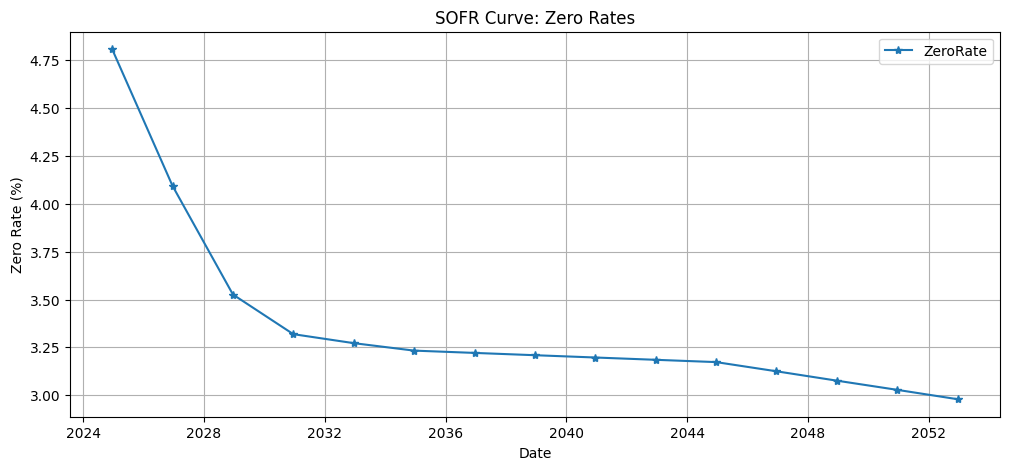

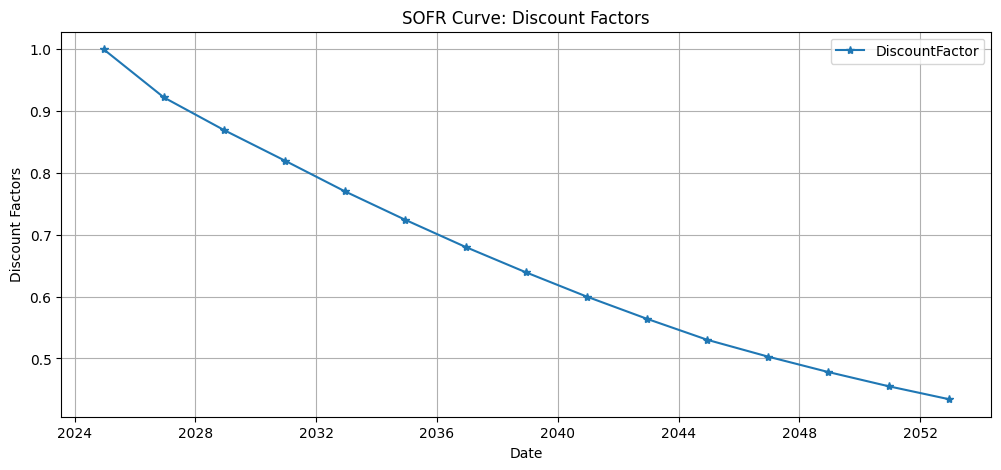

In [5]:
plt = sofr_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='SOFR Curve: Zero Rates', figsize=(12,5))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = sofr_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='SOFR Curve: Discount Factors', figsize=(12,5))
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

## d. Validate SOFR calibration by pricing SOFR swaps

In [6]:
# validate SOFR swaps
sofr_index = ql.Sofr(sofr_yield_curve_handle)
# swap_engine = ql.DiscountingSwapEngine(sofr_yield_curve_handle)

print('SOFR Swap valuation: PVs should be close to zero!')

for (SOFR_tenor, SOFR_rate) in zip(SOFR_tenors, SOFR_rates):    
    start_date = calendar.advance(calc_date, settle_days, ql.Days)
    schedule = ql.MakeSchedule(start_date, calendar.advance(start_date, SOFR_tenor), ql.Period('1Y'), calendar=calendar)        
    oisSwap = ql.MakeOIS(SOFR_tenor, sofr_index, SOFR_rate/100, nominal=100)
    
    # oisSwap.setPricingEngine(swap_engine)
    print('Swap PV for', SOFR_tenor, 'tenor /', SOFR_rate, 'coupon :', oisSwap.NPV()) 
    

SOFR Swap valuation: PVs should be close to zero!
Swap PV for 1Y tenor / 4.81 coupon : -0.0019039252059656064
Swap PV for 2Y tenor / 4.11 coupon : -0.0038959733583743272
Swap PV for 3Y tenor / 3.73 coupon : -0.00427496381229453
Swap PV for 5Y tenor / 3.38 coupon : -0.0039725855054122405
Swap PV for 7Y tenor / 3.32 coupon : -0.004370911579812287
Swap PV for 10Y tenor / 3.26 coupon : -0.004266308829279808
Swap PV for 20Y tenor / 3.2 coupon : -0.00643698870992182
Swap PV for 30Y tenor / 3.02 coupon : -0.005751582239938102


-----------------------------------------------------------
# 2. Credit Default Swaps (CDS): calibration + pricing
## a. CDS Hazard Rate calibration


In [7]:
CDS_recovery_rate = 0.4

CDS_day_count = ql.Actual360()

# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2024-12-13
CDS_spreads = [17.25, 24.09, 35.58, 55.58, 70.51, 79.92]

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, CDS_day_count, CDS_recovery_rate, sofr_yield_curve_handle)               
                for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, CDS_day_count)
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), 
                CDS_day_count.yearFraction(calc_date, hr[0]),
                hr[1] * 100,
                hazard_rate_curve.survivalProbability(hr[0])) 
                for hr in hazard_rate_curve.nodes()]

grid_dates, year_frac, hazard_rates, surv_probs = zip(*hazard_list)

hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'YearFrac': year_frac,
                                     'HazardRate': hazard_rates,
                                     'SurvivalProb': surv_probs})
print(hazard_rates_df)


         Date   YearFrac  HazardRate  SurvivalProb
0  2024-12-13   0.000000    0.284216      1.000000
1  2025-12-22   1.038889    0.284216      0.997052
2  2026-12-21   2.050000    0.521157      0.991812
3  2027-12-20   3.061111    0.999872      0.981835
4  2029-12-20   5.091667    1.477184      0.952822
5  2031-12-22   7.125000    1.897422      0.916761
6  2034-12-20  10.163889    1.789842      0.868229


## b. Plot the calibrated Hazard Rate and Survival Probability curves

Text(0.5, 0, 'Date')

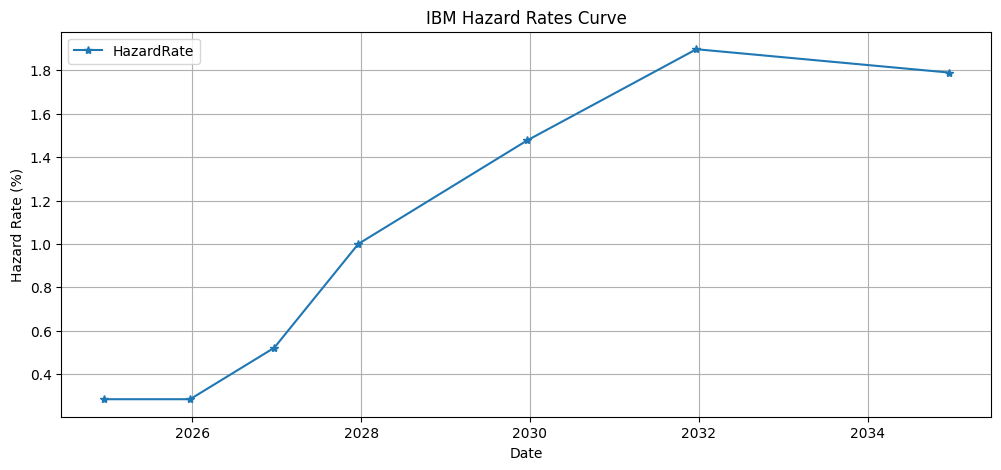

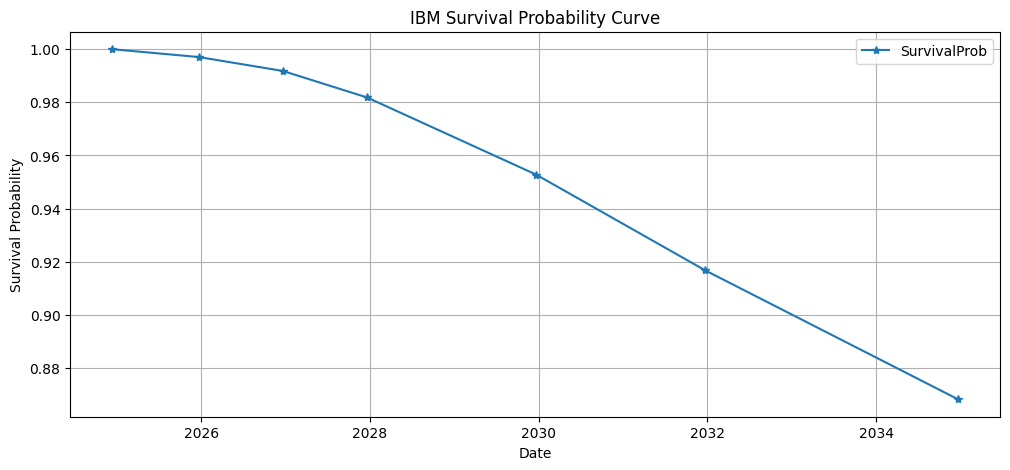

In [8]:
plt = hazard_rates_df.plot(x='Date', y='HazardRate', grid=True, style='*-', title='IBM Hazard Rates Curve', figsize=(12,5))
plt.set_ylabel('Hazard Rate (%)')
plt.set_xlabel('Date')

plt = hazard_rates_df.plot(x='Date', y='SurvivalProb', grid=True, style='*-', title='IBM Survival Probability Curve', figsize=(12,5))
plt.set_ylabel('Survival Probability')
plt.set_xlabel('Date')


## c. CDS valuation

In [9]:
# CDS specs
side = ql.Protection.Seller

face_notional = 100

contractual_spread = 100 / 10000

cds_start_date = ql.Date(13, 12, 2024)
cds_maturity_date = ql.Date(20, 12, 2029)

# Create CDS schedule
cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

# display(list(cds_schedule))

# Create CDS object
cds_obj = ql.CreditDefaultSwap(side, face_notional, contractual_spread, cds_schedule, ql.Following, ql.Actual360())

# Create CDS Implied Credit Curve and pricing engine
cds_surv_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

cds_pricing_engine = ql.MidPointCdsEngine(cds_surv_prob_curve_handle, CDS_recovery_rate, sofr_yield_curve_handle)
cds_obj.setPricingEngine(cds_pricing_engine)


# Print CDS valuation results
print('CDS protection start date:', cds_obj.protectionStartDate())
print('CDS fair/par spread:', round(cds_obj.fairSpread()*10000, 3))
print('CDS PV:', round(cds_obj.NPV(), 4))    
print('CDS Premium Leg PV:', round(cds_obj.couponLegNPV(), 4))
print('CDS Default Leg PV', round(cds_obj.defaultLegNPV(), 4))
print('Survival Prob. to Maturity:', round(hazard_rate_curve.survivalProbability(cds_maturity_date), 4))


CDS protection start date: December 13th, 2024
CDS fair/par spread: 55.489
CDS PV: 2.0243
CDS Premium Leg PV: 4.5479
CDS Default Leg PV -2.5236
Survival Prob. to Maturity: 0.9528


-----------------------------------------------------------
# 3. Pricing risky bonds in the CDS-implied Hazard Rate Model (with Credit Default Risk)
## a. Create Corporate Bond

In [10]:
issue_date = ql.Date(13, 12, 2024)
maturity_date = ql.Date(13, 12, 2029)
coupon_freq = ql.Semiannual
coupon_term = ql.Period(coupon_freq)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count_conv = ql.Unadjusted
date_generation = ql.DateGeneration.Backward
month_end = True
schedule = ql.Schedule(issue_date,
                       maturity_date,
                       coupon_term,
                       calendar,
                       day_count_conv,
                       day_count_conv,
                       date_generation,
                       month_end)

# Corp Bonds specs
day_count = ql.Thirty360(ql.Thirty360.USA)
settlement_days = 1
coupon_rate = 0.04  # 4% fixed coupon
coupons = [coupon_rate]
payment_convention = ql.Unadjusted

# Construct the FixedRateBond
face_value = 100
fixed_rate_bond = ql.FixedRateBond(
    settlement_days,
    face_value,
    schedule,
    coupons,
    day_count,
    payment_convention)

x = [(cf.date(), cf.amount()) for cf in fixed_rate_bond.cashflows()]
cf_date, cf_amount = zip(*x)
cf_frame = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowAmount': cf_amount})
print(cf_frame)


           CashFlowDate  CashFlowAmount
0       June 13th, 2025             2.0
1   December 13th, 2025             2.0
2       June 13th, 2026             2.0
3   December 13th, 2026             2.0
4       June 13th, 2027             2.0
5   December 13th, 2027             2.0
6       June 13th, 2028             2.0
7   December 13th, 2028             2.0
8       June 13th, 2029             2.0
9   December 13th, 2029             2.0
10  December 13th, 2029           100.0


## b. Price Corporate Bond on Risk-Free Yield Curve (without Credit Risk)

In [11]:
compounding = ql.Compounded
# compounding = ql.Continuous

day_counter = fixed_rate_bond.dayCounter()

risk_free_bond_engine = ql.DiscountingBondEngine(sofr_yield_curve_handle)

fixed_rate_bond.setPricingEngine(risk_free_bond_engine)
risk_free_bond_price = fixed_rate_bond.cleanPrice()
risk_free_bond_yield = fixed_rate_bond.bondYield(risk_free_bond_price, day_counter, ql.Compounded, ql.Semiannual) * 100

print('risk_free_bond_price:', risk_free_bond_price)
print('risk_free_bond_yield:', risk_free_bond_yield)


risk_free_bond_price: 102.69522423380708
risk_free_bond_yield: 3.4081877660751347


## c. Compute Intrinsic Risky Bond Price on IBM CDS Credit Curve (with Credit Risk)

In [12]:
# bond_recovery_rate
bond_recovery_rate = 0.4

# cds_curve_risky_bond_engine: using calibrated IBM CDS curve
cds_curve_risky_bond_engine = ql.RiskyBondEngine(cds_surv_prob_curve_handle, bond_recovery_rate, sofr_yield_curve_handle)
fixed_rate_bond.setPricingEngine(cds_curve_risky_bond_engine)

# 3. Calculate intrinsic risky bond on custom survival probability curve
risky_bond_price = fixed_rate_bond.cleanPrice()
risky_bond_yield = fixed_rate_bond.bondYield(risky_bond_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

print('risky_bond_price:', risky_bond_price)
print('risky_bond_yield:', risky_bond_yield)

# Compute the credit I-Spread, relative to risk-free bond (SOFR curve)
risky_bond_credit_ispread_bps = (risky_bond_yield - risk_free_bond_yield) * 100
print('risky_bond_ispread_bps:', risky_bond_credit_ispread_bps)

# Calc z-spread
risky_bond_zspread_bps = ql.BondFunctions.zSpread(fixed_rate_bond, risky_bond_price, sofr_yield_curve, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 1e4
print('risky_bond_zspread_bps:', risky_bond_zspread_bps)



risky_bond_price: 100.06002112481444
risky_bond_yield: 3.986548948287964
risky_bond_ispread_bps: 57.83611822128294
risky_bond_zspread_bps: 56.94175049808435
